## Контрольная работа CVDL, 24.10.22
Вам необходимо обучить многоклассовый классификатор изображений на train части датасета, находящегося в DATASET_PATH.
Также надо проверить что обучение сошлось, и замерять метрики на test.

Баллы:
 - работающий код тренировки с правильным лоссом и головой для задачи многоклассовой классификации: **4** балла
 - метрики precision/recall по классам по train и test: **2** балла
 - график train и test лоссов: **2** балла
 - отсутствие оверфита (по графикам train-test): **2** балла
 
Предполагается, что вы используете предобученную модель и затюните ее. Датасеты train и тест маленькие, всего по  2500 изображений, так что обучение сети с нуля приведет скорее всего к оверфиту.

In [1]:
from pathlib import Path

#######
DATASET_PATH = "/home/student/GroceryStoreDataset/dataset"
#######

DATASET_PATH = Path(DATASET_PATH)
assert DATASET_PATH.exists()

In [ ]:
# если не установлено - установить pandas
! pip install pandas

In [2]:
import pandas

In [3]:
import torch
import numpy as np
from tqdm import tqdm

In [4]:
from torchvision.datasets.folder import DatasetFolder, default_loader
from typing import Optional, Callable, Tuple, Any, List
import pandas as pd


class FoodDataset(DatasetFolder):    
    def __init__(self,
            root: str,
            classes_path: str,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            ):
        super().__init__(root=root, transform=transform, loader=default_loader, target_transform=target_transform, extensions='')
        self.root = Path(root)
        self._image_paths = self.find_images_recursively(self.root)
        self._classes_map = pd.read_csv(classes_path).set_index('Class Name (str)')['Coarse Class Name (str)']
        self._image_labels = [self.determine_sample_label(self.root, ip) for ip in self._image_paths]
        self.classes = list(dict.fromkeys(self._classes_map))
        self.samples = [
            (sample_path, self.classes.index(sample_cls))
            for (sample_path, sample_cls) in zip(self._image_paths, self._image_labels)
        ]
    
    def find_images_recursively(self, root_path):
        files = list(root_path.glob("[!.]*"))
        samples = list(f for f in files if not f.is_dir())
        subdirs = list(f for f in files if f.is_dir())
        assert len(samples) == 0 or len(subdirs) == 0, f"Can't mix subdirs and images"
        if len(subdirs):
            samples = []
            for sub_root_path in subdirs:
                samples += self.find_images_recursively(sub_root_path)
        return samples
    
    def determine_sample_label(self, root_path, sample_path):
        parts = sample_path.relative_to(root_path).parent.parts
        precise_label = parts[-1]
        coarse_label = self._classes_map[precise_label]
        return coarse_label

In [5]:
ds_train = FoodDataset(DATASET_PATH / 'train', DATASET_PATH / 'classes.csv')
ds_test = FoodDataset(DATASET_PATH / 'test', DATASET_PATH / 'classes.csv')
print(len(ds_train), len(ds_test))

2640 2485


In [6]:
ds_train.classes == ds_test.classes

True

Nectarine


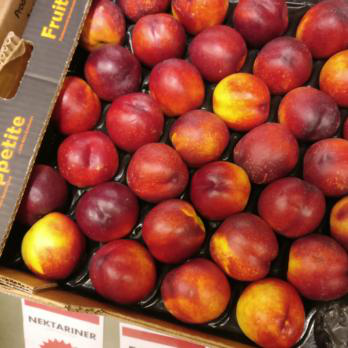

In [7]:
img, cls_idx = ds_train[750]
print(ds_train.classes[cls_idx])
img

<захотелось увидеть ещё пару примеров>

Red-Grapefruit


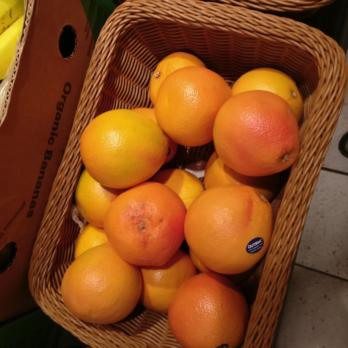

In [8]:
img, cls_idx = ds_train[23]
print(ds_train.classes[cls_idx])
img

Apple


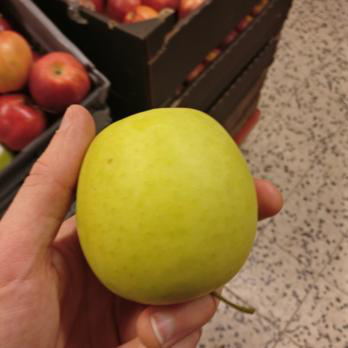

In [9]:
img, cls_idx = ds_train[147]
print(ds_train.classes[cls_idx])
img

In [20]:
ds_train[147][0].shape

torch.Size([3, 224, 224])

In [22]:
ds_train[147][1]

tensor(0)

### Подготовка к тренировке

In [7]:
N_CLASSES = len(ds_train.classes)

In [8]:
print(N_CLASSES)

43


In [9]:
import torchvision.transforms as transforms

In [10]:
target_transform = lambda x: torch.Tensor([x]).long()[0]

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        transforms.Resize((224, 224)),
    ]
)


Трансформы можно менять - например, можно добавить аугментации

In [11]:
train_transform = test_transform


In [12]:
ds_train = FoodDataset(DATASET_PATH / 'train', DATASET_PATH / 'classes.csv', transform=train_transform, target_transform=target_transform)
ds_test = FoodDataset(DATASET_PATH / 'test', DATASET_PATH / 'classes.csv', transform=test_transform, target_transform=target_transform)

In [75]:
trainloader = torch.utils.data.DataLoader(
    ds_train, batch_size=1, shuffle=True, num_workers=4
)
testloader = torch.utils.data.DataLoader(
    ds_test, batch_size=1, shuffle=False, num_workers=4
)

### Построение модели
Используйте не слишком тяжелую pretrained-модель, заморозьте ее и добавьте голову на N классов.

Важно помнить, что для некоторых слоев поведение в train/eval режимах - разное, и от этого зависит "успешность" тюнинга.

In [76]:
import torchvision.models as models

In [77]:
model_pretrained = models.resnext50_32x4d(pretrained=True)

In [78]:
print(model_pretrained)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [79]:
for i, layer in enumerate(model_pretrained.children()):
    print('i = ', i)
    print(layer)

i =  0
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
i =  1
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
i =  2
ReLU(inplace=True)
i =  3
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
i =  4
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): Batc

In [80]:
import torch.nn as nn
backbone = nn.Sequential(*(list(model_pretrained.children())[0:8]))
print(backbone)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

In [81]:
for layer in backbone:
    for name, param in layer.named_parameters():
        param.requiers_grad = False

In [111]:
t = torch.Tensor([np.random.uniform(0, 1, (2048, 7, 7))])
res1 = nn.AdaptiveAvgPool2d(output_size=(1, 1))(t)
print(res1.shape)
res2 = nn.Linear(in_features=2048, out_features=N_CLASSES, bias=True)(res1.unsqueeze(dim=2).unsqueeze(dim=3))
print(res2.shape)

torch.Size([1, 2048, 1, 1])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2048x1 and 2048x43)

In [92]:
head = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Linear(in_features=2048, out_features=N_CLASSES, bias=True),
            nn.LogSoftmax(dim=-1)
        )

In [93]:
net = torch.nn.Sequential(backbone, head)

## Лосс

In [94]:
criterion = torch.nn.NLLLoss()

In [95]:
optimizer = torch.optim.Adam(net.parameters(), lr=5e-3)

## Тренировка

Для легкого backbone с замороженными весами на batch=32 скорость train ~ 10 батчей в секунду, а в эпохе ~ 80 батчей.

Тренировка в 50 эпох займет 80batch / 10batch/s * 50ep * 2 \[train + test\] = 800s ~13min 

In [96]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [97]:
def run_1_epoch(net, optimizer, dataloader, criterion, device=None):
    # print('device = ', device)
    is_training = net.training
        
    loss_values = []    
    for num, (x, y) in enumerate((iter(dataloader))):
        x, y = x.to(device), y.to(device)
        prediction = net(x)
        loss_val = criterion(prediction, y).mean()
            
        if is_training:
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            
            if num % 100 == 0:
                loss_values.append(loss_val.detach().cpu().item())
                
        print(f"Stats: Loss={np.mean(loss_values):.2f}")
        return loss_values
    

In [98]:
def train(epochs, net, optimizer, train_data, test_data, criterion, device):
    net.to(device)
    stats = {
        "train": [],
        "test": []
    }
    for e in tqdm(range(epochs)):
        print(f"== Epoch {e} ==")
        print(f"Training:")    
        net.train()
        epoch_loss = run_1_epoch(net, optimizer, train_data, criterion, device=device)
        stats['train'].append(epoch_loss)
            
        net.eval()
        print(f"Testing:")  
        test_loss = run_1_epoch(net, optimizer, test_data, criterion, device=device)
        stats['test'].append(test_loss)
        return stats

In [99]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [100]:
print('device = ', device)

device =  cuda:0


In [101]:
train(10, net, optimizer, trainloader, testloader, criterion, device)

  0%|          | 0/10 [00:00<?, ?it/s]

== Epoch 0 ==
Training:


  0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2048x1 and 2048x43)

In [6]:
train_logs = []
train_metrics = []
val_logs = []
val_metrics = []

In [5]:
# do something

## Метрики и лосс

In [29]:
print(f"Train Precision/Recall: {train_metrics[-2:]}, \nTest Precision/Recall {val_metrics[-2:]}")

Train Precision/Recall: [0.7793789337004585, 0.6871259750712141], 
Test Precision/Recall [0.6445287578083437, 0.552591486302335]


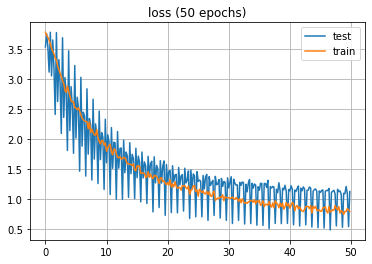

In [30]:
from matplotlib import pyplot as plt
epochs = np.arange(0, 50, 0.2)
plt.plot(epochs, val_logs, label='test')
plt.plot(epochs, train_logs, label='train')

plt.title('loss (50 epochs)')
plt.grid()
plt.legend()


### Окружение
Список пакетов в python виртуальной машины

In [7]:
! nvidia-smi

Mon Nov  1 20:02:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 470.63.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000001:00:00.0 Off |                    0 |
| N/A   49C    P8    28W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
! cat /etc/lsb-release

DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=18.04
DISTRIB_CODENAME=bionic
DISTRIB_DESCRIPTION="Ubuntu 18.04.6 LTS"


In [4]:
! python -V

Python 3.8.11


In [14]:
! pip list

Package                     Version     Editable project location
--------------------------- ----------- --------------------------------------------
aiohttp                     3.8.3
aiohttp-retry               2.8.3
aiosignal                   1.2.0
amqp                        5.1.1
antlr4-python3-runtime      4.9.3
anyio                       3.6.1
appdirs                     1.4.4
argon2-cffi                 21.3.0
argon2-cffi-bindings        21.2.0
astroid                     2.12.10
asttokens                   2.0.8
async-timeout               4.0.2
asyncssh                    2.12.0
atpublic                    3.1.1
attrs                       22.1.0
Babel                       2.10.3
backcall                    0.2.0
beautifulsoup4              4.11.1
billiard                    3.6.4.0
black                       22.10.0
bleach                      5.0.1
brotlipy                    0.7.0
cachetools                  5.2.0
celery                      5.2.7
certifi              


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip
